# Assignment1 - Facial Landmark Detection Model

## Student Name: Bhavna Panwar
## Student ID: 100802837

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [73]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [74]:
link = "https://drive.google.com/open?id=1uKOcbFBGRZezTrN_zWlp2VzEMly5LJUs"

In [75]:
dataset = drive.CreateFile({'id':id}) 
dataset.GetContentFile('training.csv')  
dataset = pd.read_csv('training.csv')

In [76]:
dataset.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [77]:
def plot_sample(X,y,axs):
  '''
  kaggle picture is 96 by 96
  y is rescaled to range between -1 and 1
  '''
  
  axs.imshow(X.reshape(96,96),cmap="gray")
  axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

In [78]:
def load():
  
  
  dataset['Image'] = dataset['Image'].apply(lambda im: np.fromstring(im, sep=' '))
  
  dataset.fillna(method = "ffill", inplace = True) 
  
  X = np.vstack(dataset['Image'].values) / 255.  # changes valeus between 0 and 1
  
  X = X.astype(np.float32)

  
  ## standardization of the response
  y = dataset[dataset.columns[:-1]].values
  y = (y - 48) / 48  # y values are between [-1,1]
  X, y = shuffle(X, y, random_state=42)  # shuffle data
  y = y.astype(np.float32)

  return X, y


In [79]:
def load2dataset():

  dataset = load()
  
  X = dataset[0].reshape(-1,96,96,1)
  y = dataset[1]

  return X, y

In [80]:
X, y = load2dataset()


In [81]:
X.shape

(7049, 96, 96, 1)

In [82]:
y.shape

(7049, 30)

In [83]:
from tensorflow.keras.layers import MaxPooling2D, Conv2D , Flatten, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Sequential

In [84]:
def model():
  model = Sequential()

  model.add(Conv2D(16, (2,2),padding="same",activation="relu",input_shape=(96,96,1)))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(32, (3, 3) ,activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3) ,activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (2, 2) ,activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(512, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.1))

  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.1))

  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.1))

  model.add(Dense(30))


  model.summary()
  
  return model

In [85]:
face_model = model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 16)        80        
_________________________________________________________________
dropout_24 (Dropout)         (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 23, 23, 32)       

In [86]:
face_model.compile(optimizer='adam',loss='mse',metrics=['mae','accuracy'])

In [87]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/gdrive/My Drive/face_weights'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt1_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [89]:
auth.authenticate_user()
gauth2 = GoogleAuth()
gauth2.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth2)

In [90]:
data_test = drive.CreateFile({'id':id_test}) 
data_test.GetContentFile('test.csv')  
data_test = pd.read_csv('test.csv')

In [91]:
history = face_model.fit(X,y, epochs=100,validation_split=0.2,verbose=1, callbacks = [checkpoint_callback])

Epoch 1/100
177/177 [==============================] - 3s 11ms/step - loss: 0.0832 - mae: 0.1940 - accuracy: 0.3217 - val_loss: 0.0040 - val_mae: 0.0431 - val_accuracy: 0.6440
Epoch 2/100
177/177 [==============================] - 2s 10ms/step - loss: 0.0091 - mae: 0.0707 - accuracy: 0.4859 - val_loss: 0.0036 - val_mae: 0.0384 - val_accuracy: 0.6440
Epoch 3/100
177/177 [==============================] - 2s 10ms/step - loss: 0.0063 - mae: 0.0564 - accuracy: 0.5410 - val_loss: 0.0035 - val_mae: 0.0373 - val_accuracy: 0.6440
Epoch 4/100
177/177 [==============================] - 2s 10ms/step - loss: 0.0054 - mae: 0.0505 - accuracy: 0.5655 - val_loss: 0.0035 - val_mae: 0.0391 - val_accuracy: 0.6440
Epoch 5/100
177/177 [==============================] - 2s 10ms/step - loss: 0.0052 - mae: 0.0485 - accuracy: 0.5761 - val_loss: 0.0034 - val_mae: 0.0382 - val_accuracy: 0.6610
Epoch 6/100
177/177 [==============================] - 2s 10ms/step - loss: 0.0048 - mae: 0.0461 - accuracy: 0.6034 - va

In [92]:
import matplotlib.pyplot as plt
def plot_curves(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [93]:
history.history.keys()

dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])

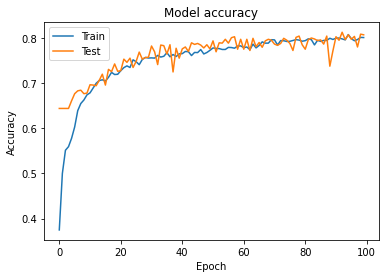

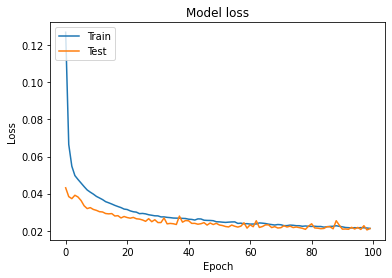

In [94]:
plot_curves(history)

In [95]:
face_model = model()
face_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 96, 96, 16)        80        
_________________________________________________________________
dropout_32 (Dropout)         (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 23, 23, 32)       

In [96]:
data_test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [97]:
type(data_test['Image'][0])

str

In [98]:
def load_test():
  
  
  data_test['Image'] = data_test['Image'].apply(lambda im: np.fromstring(im, sep=' '))
  
  X_test = np.vstack(data_test['Image'].values) / 255.  # changes valeus between 0 and 1
  
  X_test = X_test.astype(np.float32)

  return X_test

In [99]:
temp_test = load_test()

In [100]:
temp_test.shape

(1783, 9216)

In [101]:
X_test = temp_test.reshape(-1, 96, 96, 1)

In [102]:
X_test.shape

(1783, 96, 96, 1)

In [103]:
y_pred = face_model.predict(X_test)

In [104]:
len(y_pred)

1783

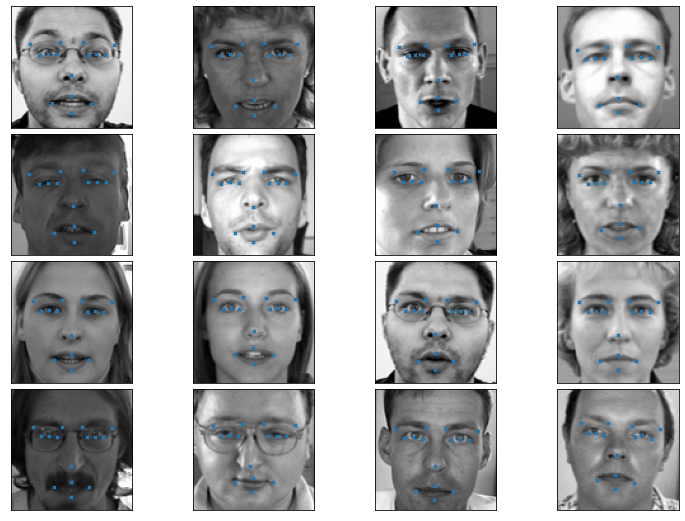

In [105]:
def plot_sample(x, y, axis):
  img = x.reshape(96, 96)
  axis.imshow(img, cmap='gray')
  axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)


fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
  left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
  axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
  plot_sample(X_test[i], y_pred[i], axis)

plt.show()